# **Network Science Project**
## Game reccomandation system using [Steam user reviews](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam)

### Author: Guglielmo Berzano
#### email: guglielmo.berzano@studenti.unimi.it
#### Academic year: 2023-2024


<figure>
    <img src="https://logos-world.net/wp-content/uploads/2020/10/Steam-Logo.png" width="185" height="100">
    <figcaption>Steam logo.</figcaption>
</figure>

Importing the libraries:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
from google.colab import drive
import pickle
import scipy.stats
from statsmodels.distributions.empirical_distribution import ECDF

#!pip uninstall python-louvain --> unistall and reinstall because it gave me many problems
#!pip install python-louvain
#import community

# !pip install node2vec
# from node2vec import Node2Vec

drive.mount("/content/drive")


#importing the main files so that I do not have to run the entire script every time
reduced_pairs = pickle.load(open("/content/drive/MyDrive/Network Science project/" + "reduced_pairs.pickle","rb"))
dataset=pd.read_csv("/content/drive/MyDrive/Network Science project/final_ds.csv")

Mounted at /content/drive


In [2]:
dataset.head()

,app_id,user_id,title
0,975370,51580,Dwarf Fortress
1,703080,259432,Planet Zoo
2,534380,22793,Dying Light 2 Stay Human
3,518790,271318,theHunter: Call of the Wild™
4,1794680,337740,Vampire Survivors


In [3]:
for group in dataset.groupby("user_id"):



  user_games = list(group[1]["app_id"])


  print(user_games)
  print("\n")
  #print(working_group)
  print("\n")
  print("User id: " + str(group[0])+ "\n")
  print(group[1]) #no more than 2
  break

[534380, 1174180, 1172380, 4500, 1302240, 301640, 1593500]




User id: 36

         app_id  user_id                                title
155712   534380       36             Dying Light 2 Stay Human
239870  1174180       36                Red Dead Redemption 2
568380  1172380       36        STAR WARS Jedi: Fallen Order™
585447     4500       36  S.T.A.L.K.E.R.: Shadow of Chernobyl
729300  1302240       36                         Labyrinthine
860587   301640       36                  Zombie Army Trilogy
912672  1593500       36                           God of War


In [4]:
pairs = defaultdict(lambda: 0)

for group in dataset.groupby("user_id"):

  rec_games = list(group[1]["app_id"])

  for i in range(len(rec_games)):

    for j in range(i+1, len(rec_games)):

      pairs[(rec_games[i], rec_games[j])] += 1

In [5]:
#pickle_in = open( "/content/drive/MyDrive/Network Science project/"+"pairs.pickle","rb")
#pairs = pickle.load(pickle_in)
pairs_ds=pd.DataFrame(pairs.items(), columns=["source_id, target_id", "weight"])
pairs_ds[["source_id", "target_id"]]=pd.DataFrame(pairs_ds['source_id, target_id'].tolist(), index=pairs_ds.index)
pairs_ds.drop('source_id, target_id', axis=1, inplace=True)
pairs_ds

,weight,source_id,target_id
0,106,534380,1174180
1,53,534380,1172380
2,18,534380,4500
3,10,534380,1302240
4,5,534380,301640
...,...,...,...
2858277,1,1834870,561770
2858278,1,1834870,1369320
2858279,1,1698960,561770
2858280,1,1698960,1369320


With the following code we eliminate duplicates: if a couple is present in both combination `source_id-target_id` and `target_id-source_id` they will be combined and the weights

In [6]:
pairs_df_no_dupli=pairs_ds.copy()
pairs_df_no_dupli[['source_id', 'target_id']]=pd.DataFrame(np.sort(pairs_df_no_dupli[['source_id', 'target_id']].to_numpy(), axis=1))
pairs_df_no_dupli=pairs_df_no_dupli.groupby(["source_id","target_id"], sort=False, as_index=False)["weight"].sum()
pairs_df_no_dupli

,source_id,target_id,weight
0,534380,1174180,283
1,534380,1172380,89
2,4500,534380,18
3,534380,1302240,10
4,301640,534380,5
...,...,...,...
2557483,561770,1545820,1
2557484,561770,1740100,1
2557485,561770,1834870,1
2557486,561770,1698960,1


In [ ]:
#sanity check
test_for_cicle=pairs_df_no_dupli[pairs_df_no_dupli.source_id==534380] #select a value at random to check
test_for_cicle.reset_index(inplace=True, drop=True)

print(test_for_cicle)

for i in test_for_cicle["target_id"]:
  control_ds=pairs_df_no_dupli[(pairs_df_no_dupli.source_id==i) & (pairs_df_no_dupli.target_id==534380)]
  if control_ds.shape[0]!=0:
    print(i)

      source_id  target_id  weight
0        534380    1174180     283
1        534380    1172380      89
2        534380    1302240      10
3        534380    1593500     231
4        534380    1122720       1
...         ...        ...     ...
1848     534380    2065330       1
1849     534380    1590320       1
1850     534380     966320       1
1851     534380     603320       1
1852     534380    1106340       1

[1853 rows x 3 columns]


# Graph creation

Two nodes will have one link if the column weight is $≥$ than 15. This value was found after many empirical experiments.

In [7]:
reduced_pairs=pairs_df_no_dupli[pairs_df_no_dupli["weight"]>=15]
reduced_pairs.loc[:,"weight"]=pd.Series(reduced_pairs["weight"])-14

<ipython-input-7-e485401684bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_pairs.loc[:,"weight"]=pd.Series(reduced_pairs["weight"])-14


In [8]:
#graph creation with weight 15
G_w15=nx.from_pandas_edgelist(reduced_pairs,
                          source="source_id",
                          target="target_id",
                          edge_attr="weight",
                          create_using=nx.Graph())

print(G_w15)

Graph with 2356 nodes and 60115 edges


In [ ]:
#gephi-friendly graph
reduced_pairs.rename(columns={"source_id":"source",
                              "target_id":"target"}).to_csv("Gephi_w15.csv",index=False) #saving this to create the beautiful gephi plot

In [9]:
print(f"""Original number of links: {pairs_df_no_dupli.shape[0]}\n
Reduced number of links: {reduced_pairs.shape[0]}\n
Percentage of mantained links: {round(reduced_pairs.shape[0]*100/pairs_df_no_dupli.shape[0],2)}%""")

Original number of links: 2557488

Reduced number of links: 60115

Percentage of mantained links: 2.35%


In [ ]:
graph_degrees=dict(G_w15.degree())

print(f"Min Degree: ", min(graph_degrees.values()))
print(f"Max Degree: ", max(graph_degrees.values()))
print(f"Average Degree: ", np.mean(pd.Series(graph_degrees.values())))
print(f"Median Degree: ", np.median(pd.Series(graph_degrees.values())))
print(f"Std: ", np.std(pd.Series(graph_degrees.values())))

# Calculate connected components
print(f"Nr of connected components: {nx.number_connected_components(G_w15)}")


# bridges
bridges = list(nx.bridges(G_w15))
percentage_bridges = (len(bridges) / G_w15.number_of_edges()) * 100
print(f"Number of bridges: {len(bridges)}")
print(f"Percentage bridges: {percentage_bridges:.2f}%")

#density
print(f"Network density: {nx.density(G_w15)}")

#transitivity and avg clustering coefficient
print(f"Global clustering coefficient:{nx.transitivity(G_w15)}\
      \nAverage local clustering coefficient: {nx.average_clustering(G_w15)}")

Min Degree:  1
Max Degree:  1054
Average Degree:  51.031409168081495
Median Degree:  7.0
Std:  106.50166724290511
Nr of connected components: 68
Number of bridges: 387
Percentage bridges: 0.64%
Network density: 0.021669388181775582
Global clustering coefficient:0.3883550518298757      
Average local clustering coefficient: 0.6588415323049774


## Graph analysis on nodes' degree

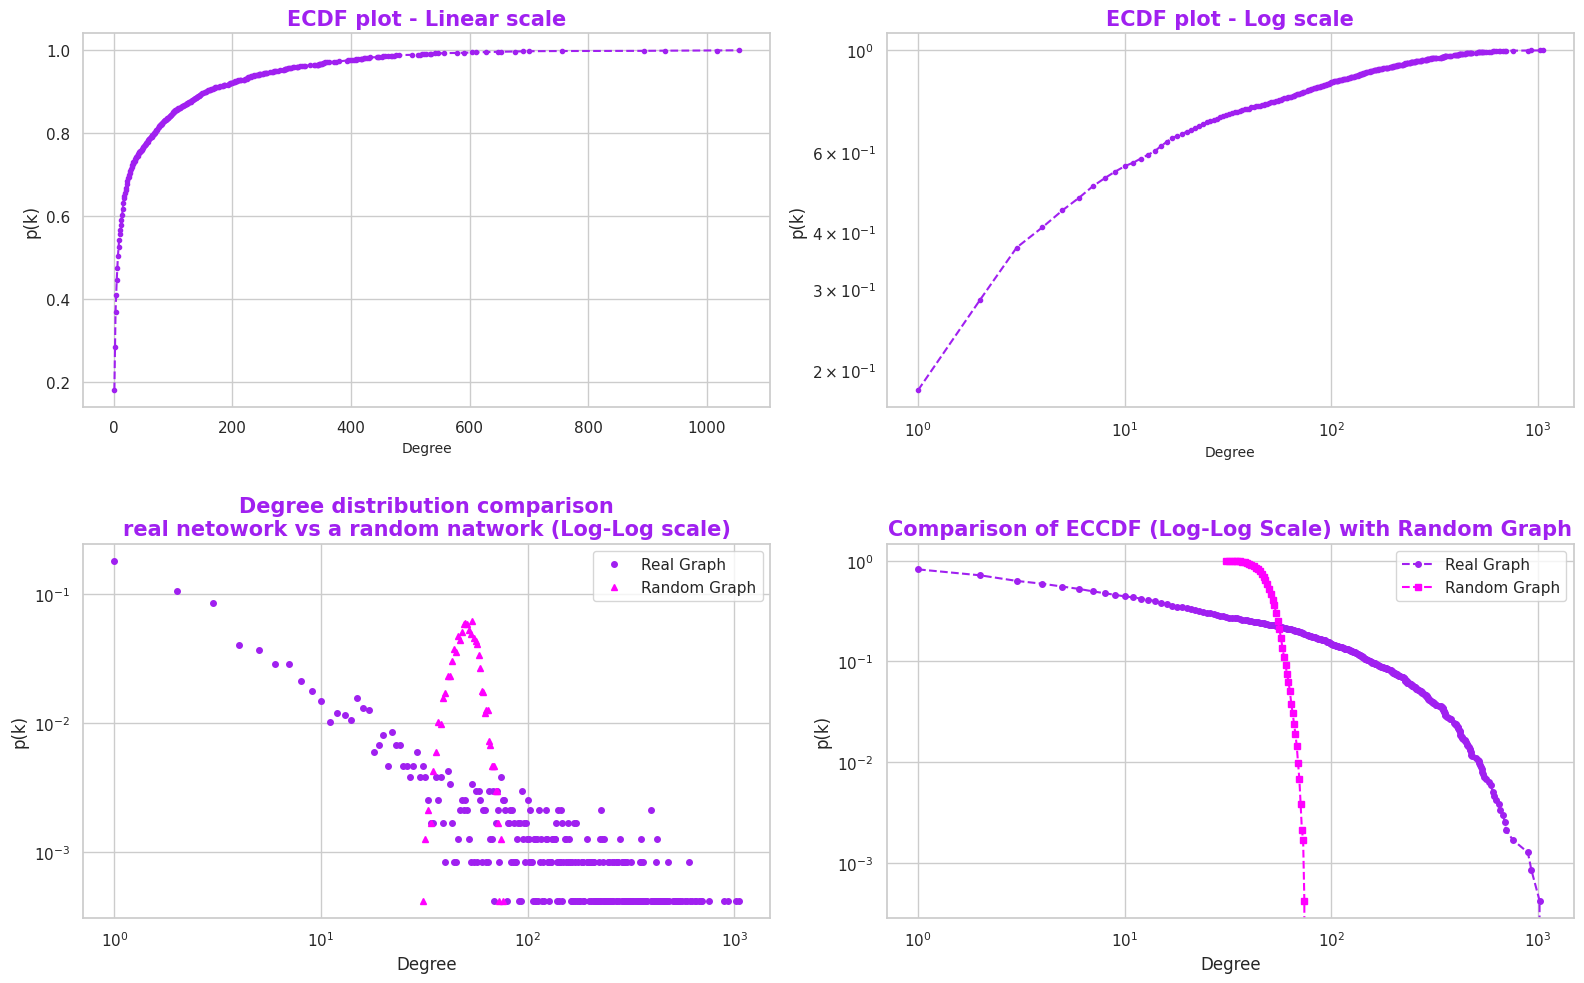

In [ ]:
graph_degrees=dict(G_w15.degree())
# Compute ECDF
cdf_function = ECDF(pd.Series(graph_degrees.values()))
x = np.unique(pd.Series(graph_degrees.values()))
y = cdf_function(x)
eccdf_y = 1 - cdf_function(x)
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 10))


# Plot ECDF in linear scale
axs[0, 0].plot(x, y, color="#A020F0", linestyle='--', marker='o', ms=3)
axs[0, 0].set_xlabel('Degree', size=10)
axs[0,0].set_ylabel('p(k)', size=12)
axs[0, 0].set_title("ECDF plot - Linear scale", size=15, color="#A020F0", fontweight="bold")
axs[0, 0].grid(True)

# Plot ECDF in log scale
axs[0, 1].loglog(x, y, color="#A020F0", linestyle='--', marker='o', ms=3)
axs[0, 1].set_xlabel('Degree', size=10)
axs[0,1].set_ylabel('p(k)', size=12)
axs[0, 1].set_title("ECDF plot - Log scale", size=15, color="#A020F0", fontweight="bold")
axs[0,1].grid(True)



n_nodes = len(G_w15.nodes)
n_edges = len(G_w15.edges)
p = n_edges / (n_nodes * (n_nodes - 1) / 2)
# Edge probability for Erdős–Rényi model
random_graph = nx.erdos_renyi_graph(n_nodes, p)
random_degrees = dict(random_graph.degree())
random_degree_values = list(random_degrees.values())

degrees = list(dict(G_w15.degree()).values())
degree_count = defaultdict(int)

for degree in degrees:
 degree_count[degree] +=1

degree_count = dict(sorted(degree_count.items()))

p_k = []
for degree in degree_count.values():
  p_k.append(degree/sum(degree_count.values()))

random_count = defaultdict(int)

for degree in random_degree_values:
 random_count[degree] +=1

random_count = dict(sorted(random_count.items()))

rand_p_k = []

for degree in random_count.values():
  rand_p_k.append(degree/sum(random_count.values()))


axs[1, 0].set_title('\nDegree distribution comparison\nreal netowork vs a random natwork (Log-Log scale)', size=15, color="#A020F0", fontweight="bold")
axs[1, 0].loglog(degree_count.keys(),p_k,'o',markersize=4,color='#A020F0', label="Real Graph")
axs[1, 0].loglog(random_count.keys(),rand_p_k,"^",markersize=4,color="magenta", label="Random Graph")
axs[1,0].set_xlabel('Degree', size=12)
axs[1,0].set_ylabel('p(k)', size=12)
axs[1,0].legend()


# Calculate degree and ECCDF for the random graph
random_cdf_function = ECDF(random_degree_values)
random_eccdf_y = 1 - random_cdf_function(np.unique(random_degree_values))
axs[1,1].loglog(x, eccdf_y, color="#A020F0", linestyle='--', marker='o', ms=4, label='Real Graph')
# Plot ECCDF for rn
axs[1,1].loglog(np.unique(random_degree_values), random_eccdf_y, color="magenta", linestyle='--', marker='s', ms=5, label='Random Graph')
axs[1,1].set_xlabel('Degree', size=12)
axs[1,1].set_ylabel('p(k)', size=12)
axs[1,1].set_title('\nComparison of ECCDF (Log-Log Scale) with Random Graph', size=15, color="#A020F0", fontweight="bold")
axs[1,1].legend()
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

&uarr; &uarr;

Scale free graph behaviour! Many nodes with very low degree and few nodes with extremely large degree. This situation is not captured at all by the random network of Erdős–Rényi.

## Centrality analysis

In this case I will analyse four types of centralities:

- **degree**: the more links a node has the higher its centrality &rarr; if you have many links you will be important.
- **betweenness**: how important a node is for information flow. If to move information from a part of the graph to another we are forced to pass through a particular node, than that node will be very "between-central".
- **closeness**: how close nodes are to other nodes on average. In this case we are analysing how fast information can move through nodes &rarr; if a node has many links, it will be easier to reach other nodes &rarr; high closeness centrality.
- **eigenvector**: evolution of the degree centrality. In this case you are not important based on how many links you have but on how important your neighbors are &rarr; the centrality is weighted.

In [ ]:
# Calculate and display top 5 degree centrality
degree_centrality = nx.degree_centrality(G_w15)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_degree_centrality = sorted_degree_centrality[:5]
print("Top 5 Degree Centrality:")
for node, centrality in top_5_degree_centrality:
    title = dataset[dataset['app_id']==node].iloc[0][2]
    print(f"Game: {title}, {centrality:.4f}")

#Calculate and display top 5 betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_w15)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_betweenness_centrality = sorted_betweenness_centrality[:5]
print("\nTop 5 Betweenness Centrality:")
for node, centrality in top_5_betweenness_centrality:
    title = dataset[dataset['app_id']==node].iloc[0][2]
    print(f"Game: {title}, {centrality:.4f}")

#Calculate and display top 5 closeness centrality
closeness_centrality = nx.closeness_centrality(G_w15)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_closeness_centrality = sorted_closeness_centrality[:5]
print("\nTop 5 Closeness Centrality:")
for node, centrality in top_5_closeness_centrality:
    title = dataset[dataset['app_id']==node].iloc[0][2]
    print(f"Game: {title}, {centrality:.4f}")

# Calculate and display top 5 eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_w15)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_eigenvector_centrality = sorted_eigenvector_centrality[:5]
print("\nTop 5 Eigenvector Centrality:")
for node, centrality in top_5_eigenvector_centrality:
    title = dataset[dataset['app_id']==node].iloc[0][2]
    print(f"Game: {title}, {centrality:.4f}")

Top 5 Degree Centrality:
Game: Stray, 0.4476
Game: Left 4 Dead 2, 0.4318
Game: Vampire Survivors, 0.3945
Game: Call of Duty®, 0.3792
Game: Marvel’s Spider-Man Remastered, 0.3206

Top 5 Betweenness Centrality:
Game: Stray, 0.1349
Game: Left 4 Dead 2, 0.1230
Game: Vampire Survivors, 0.0876
Game: Call of Duty®, 0.0500
Game: Cult of the Lamb, 0.0327

Top 5 Closeness Centrality:
Game: Stray, 0.5936
Game: Left 4 Dead 2, 0.5857
Game: Vampire Survivors, 0.5668
Game: Call of Duty®, 0.5558
Game: Marvel’s Spider-Man Remastered, 0.5349

Top 5 Eigenvector Centrality:
Game: Left 4 Dead 2, 0.0950
Game: Stray, 0.0946
Game: Call of Duty®, 0.0941
Game: Vampire Survivors, 0.0909
Game: Project Zomboid, 0.0894


We may check the Pearson correlation between the centrality measures.

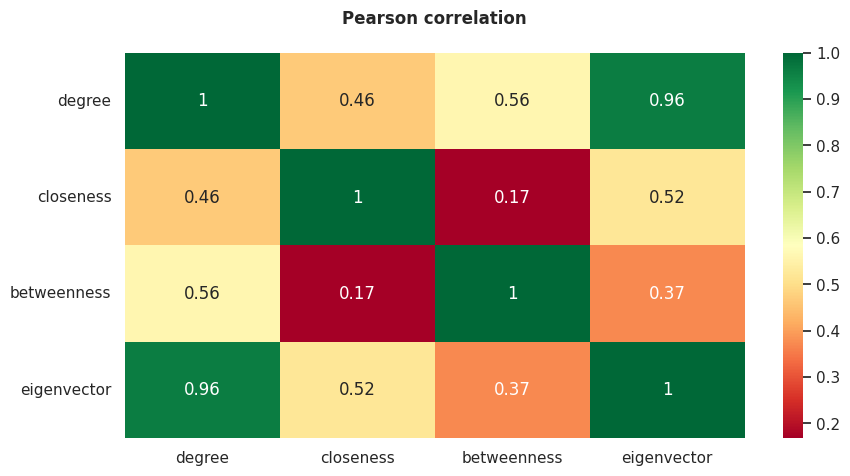

In [ ]:
all_centr = [degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']

plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap="RdYlGn")
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()

&uarr; &uarr;

Betweenness and Closeness are almost uncorrelated, Degree and Eigenvector are almost the same.

### Connected component analysis

In [ ]:
#compute the length of each connected component
len_components = [len(c) for c in nx.connected_components(G_w15)]

#find the components themselves
components = [c for c in nx.connected_components(G_w15)]

#create a subgraph of G_w15 by only selecting the nodes that are in the largest component
lcc = G_w15.subgraph(components[0])
print(f"Number of nodes: {lcc.number_of_nodes()}")
print(f"\nNumber of edges: {lcc.number_of_edges()}")

#average shortest path
avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(f"\nAverage shortest path: {avg_shrt_path_len_lcc}")

diam_lcc = nx.diameter(lcc)
print(f"\nDiameter of the largest connected component: {diam_lcc}")

#largest component info
largest_component = len_components[0]/sum(len_components)
print(f"Percentage of largest cc: {largest_component}")
components_count = defaultdict(int)

for comp in len_components:
  components_count[comp] +=1

#characteristics of the largest connected component
components_count

Number of nodes: 2205

Number of edges: 60014

Average shortest path: 2.5774394936437974

Diameter of the largest connected component: 8
Percentage of largest cc: 0.9359083191850595


defaultdict(int, {2205: 1, 3: 9, 2: 54, 4: 4})

In [ ]:
print(f"Percentage of nodes in the largest connected components: {round(lcc.number_of_nodes()/G_w15.number_of_nodes()*100, 2)}%")
print(f"Percentage of edges in the largest connected components: {round(lcc.number_of_edges()/G_w15.number_of_edges()*100, 2)}%")

Percentage of nodes in the largest connected components: 93.59%
Percentage of edges in the largest connected components: 99.83%


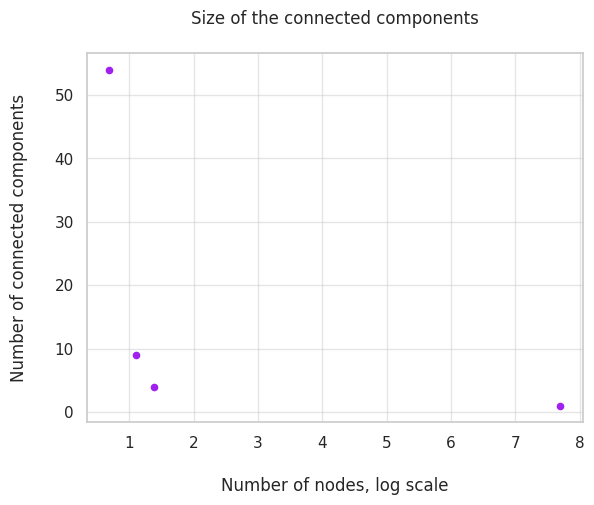

In [ ]:
plt.scatter(x=[np.log(i) for i in components_count.keys()], y=list(components_count.values()), color="#A020F0", s=20)
sns.set(style="whitegrid")
plt.title("Size of the connected components\n")
plt.xlabel("\nNumber of nodes, log scale")
plt.ylabel("Number of connected components\n")
plt.grid(alpha=0.5)

plt.show()

## The analysis continues - Louvain community detection

In [ ]:
communities=community.best_partition(G_w15)
print(pd.Series(communities.values()).unique())
print(len(communities.values()))

#gephi files -> used to make communities on gephi
communities_df=pd.DataFrame({"Id": list(communities.keys()),
    "Index": pd.Series(communities.values())+1 #add one because gephi does not conceive 0 as a valid community value
              })
communities_df.to_csv("Community index.csv", index=False)


communities_df

[  0   1   2   3   4   5   6   7  13  16  10  11  12  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114   8   9  56]
2356


,Id,Index
0,534380,1
1,1174180,1
2,1172380,1
3,4500,2
4,1593500,1
...,...,...
2351,1118240,4
2352,1160220,4
2353,1293180,4
2354,249230,110


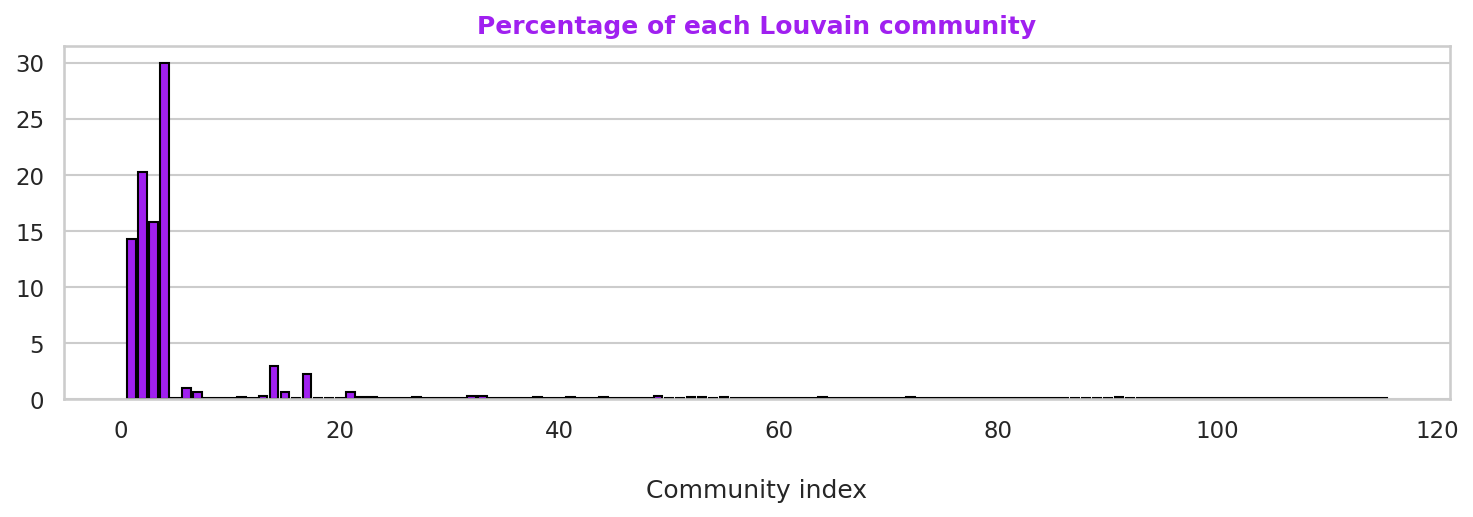

In [ ]:
# plotting the percentage importance of each community. A bit stretched, I know :*

plt.figure(figsize = (10,3), dpi=150)
plt.bar(x=range(1,116),height=pd.DataFrame(communities_df.groupby("Index").count()/communities_df.shape[0]*100)["Id"],
        color='#A020F0', edgecolor='black')
sns.set(style="whitegrid")
plt.tight_layout()
plt.grid(alpha=0, axis="x")
plt.xlabel("\nCommunity index")
plt.title("Percentage of each Louvain community", color="#A020F0", fontweight="bold")
plt.show()

Now we may check what it is contained in the communities, at least in the first four communities which are the most important $\sim$ the most frequent.

In [ ]:
#save the first four communities
first_4_com=communities_df[(communities_df["Index"]==1) | (communities_df["Index"]==2)| (communities_df["Index"]==3)| (communities_df["Index"]==4)]
for i in range(1,5): #retrieve a sample of five elements to analyse whether there is a relation or not
  communities=first_4_com[first_4_com['Index']==i]['Id'][:5]
  for j in communities:
    print(f"The {i} community is formed by: {np.unique(dataset[dataset['app_id']==j]['title'])}")
  print("\n")

The 1 community is formed by: ['Dying Light 2 Stay Human']
The 1 community is formed by: ['Red Dead Redemption 2']
The 1 community is formed by: ['STAR WARS Jedi: Fallen Order™']
The 1 community is formed by: ['God of War']
The 1 community is formed by: ['The Witcher® 3: Wild Hunt']


The 2 community is formed by: ['S.T.A.L.K.E.R.: Shadow of Chernobyl']
The 2 community is formed by: ['Left 4 Dead 2']
The 2 community is formed by: ['Outcore: Desktop Adventure']
The 2 community is formed by: ['Team Fortress 2']
The 2 community is formed by: ['Everlasting Summer']


The 3 community is formed by: ['The Elder Scrolls® Online']
The 3 community is formed by: ['Insurgency: Sandstorm']
The 3 community is formed by: ['War Thunder']
The 3 community is formed by: ['Euro Truck Simulator 2']
The 3 community is formed by: ['Raft']


The 4 community is formed by: ['Celeste']
The 4 community is formed by: ['Cult of the Lamb']
The 4 community is formed by: ['Stray']
The 4 community is formed by: ['Heart

&uarr; &uarr;

It seems that there is no real relation among games **in the same community**.

# Machine learning part, Node2Vec implementation



<figure>
    <img src="https://miro.medium.com/v2/resize:fit:2000/1*3pmstIOig4Qc3lrQS4xrNg.png" width="730" height="225">
    <figcaption>Node2Vec functioning.</figcaption>
</figure>

In [ ]:
def recommend(game_name, model):

  game_id=dataset[dataset["title"]==game_name]["app_id"].iloc[0]
  print(f"Original game: {game_name}\n")

  for index, game in enumerate(model.wv.most_similar(str(game_id))[:9]):
      rec_games=dataset[dataset["app_id"]==int(list(game)[0])].reset_index(drop=True).loc[0]["title"]
      print(f"{index+1} Game recommended: {rec_games}")
  print("\n")

In [ ]:
#DFS-BFS hybrid -> not used in the presentation

node2vec = Node2Vec(G_w15,dimensions=64,walk_length=30,num_walks=200,p=2,q=3,workers=2)
model1 = node2vec.fit(window=6,min_count=1,batch_words=3)

Computing transition probabilities:   0%|          | 0/2356 [00:00<?, ?it/s]

In [ ]:
recommend("Outlast",model1)
recommend("Arma 3",model1)
recommend("Portal 2",model1)
recommend("For The King",model1)
recommend("Counter-Strike: Global Offensive",model1)

Original game: Outlast

1 Game recommended: Outlast 2
2 Game recommended: Dying Light
3 Game recommended: Little Nightmares
4 Game recommended: CASE 2: Animatronics Survival
5 Game recommended: Tomb Raider
6 Game recommended: The Beast Inside
7 Game recommended: Slender: The Arrival
8 Game recommended: Friday the 13th: The Game
9 Game recommended: Grand Theft Auto IV: The Complete Edition


Original game: Arma 3

1 Game recommended: Squad
2 Game recommended: Arma 2: Operation Arrowhead
3 Game recommended: Hell Let Loose
4 Game recommended: Insurgency: Sandstorm
5 Game recommended: Ready or Not
6 Game recommended: Post Scriptum
7 Game recommended: GROUND BRANCH
8 Game recommended: War Thunder
9 Game recommended: Arma Reforger


Original game: Portal 2

1 Game recommended: Portal
2 Game recommended: Half-Life 2
3 Game recommended: We Become What We Behold [Fan-Made Port]
4 Game recommended: Half-Life
5 Game recommended: Among Us
6 Game recommended: Team Fortress 2
7 Game recommended: Rog

In [ ]:
#BFS -> p=1, q=4

node2vec = Node2Vec(G_w15,dimensions=64,walk_length=30,num_walks=200,p=1,q=4,workers=2)
model2 = node2vec.fit(window=6,min_count=1,batch_words=3)

Computing transition probabilities:   0%|          | 0/2356 [00:00<?, ?it/s]

In [ ]:
recommend("Outlast",model2)
recommend("Arma 3",model2)
recommend("Portal 2",model2)
recommend("For The King",model2)
recommend("Counter-Strike: Global Offensive",model2)

Original game: Outlast

1 Game recommended: Outlast 2
2 Game recommended: Dying Light
3 Game recommended: Little Nightmares
4 Game recommended: CASE 2: Animatronics Survival
5 Game recommended: Slender: The Arrival
6 Game recommended: Grand Theft Auto IV: The Complete Edition
7 Game recommended: Party Hard
8 Game recommended: Amnesia: A Machine for Pigs
9 Game recommended: Tomb Raider


Original game: Arma 3

1 Game recommended: Arma 2: Operation Arrowhead
2 Game recommended: Squad
3 Game recommended: Insurgency: Sandstorm
4 Game recommended: Hell Let Loose
5 Game recommended: Ready or Not
6 Game recommended: GROUND BRANCH
7 Game recommended: DCS World Steam Edition
8 Game recommended: War Thunder
9 Game recommended: Post Scriptum


Original game: Portal 2

1 Game recommended: Portal
2 Game recommended: Half-Life
3 Game recommended: Half-Life 2
4 Game recommended: The Backrooms Game FREE Edition
5 Game recommended: Portal Stories: Mel
6 Game recommended: Among Us
7 Game recommended: Bl

In [ ]:
#DFS -> p=4, q=1

node2vec = Node2Vec(G_w15,dimensions=64,walk_length=30,num_walks=200,p=4,q=1,workers=2)
model3 = node2vec.fit(window=6,min_count=1,batch_words=3)

Computing transition probabilities:   0%|          | 0/2356 [00:00<?, ?it/s]

In [ ]:
recommend("Outlast",model3)
recommend("Arma 3",model3)
recommend("Portal 2",model3)
recommend("For The King",model3)
recommend("Counter-Strike: Global Offensive",model3)

Original game: Outlast

1 Game recommended: Outlast 2
2 Game recommended: Slender: The Arrival
3 Game recommended: Dying Light
4 Game recommended: CASE 2: Animatronics Survival
5 Game recommended: Little Nightmares
6 Game recommended: The Beast Inside
7 Game recommended: Layers of Fear (2016)
8 Game recommended: Party Hard
9 Game recommended: Friday the 13th: The Game


Original game: Arma 3

1 Game recommended: Arma 2: Operation Arrowhead
2 Game recommended: Squad
3 Game recommended: DCS World Steam Edition
4 Game recommended: Hell Let Loose
5 Game recommended: Insurgency: Sandstorm
6 Game recommended: GROUND BRANCH
7 Game recommended: Rising Storm 2: Vietnam
8 Game recommended: War Thunder
9 Game recommended: Ready or Not


Original game: Portal 2

1 Game recommended: Portal
2 Game recommended: Portal Stories: Mel
3 Game recommended: Half-Life 2
4 Game recommended: Portal Reloaded
5 Game recommended: The Backrooms Game FREE Edition
6 Game recommended: Half-Life
7 Game recommended: Am

### That's it!!

The algorithm performed decently, not perfectly. The Steam page _Similar games_, suggests usually different games than the ones found by the Node2Vec. This is for sure because they use many more information than the ones I used.

Still the results are more than acceptable given the comupation power I had at my disposal!

For any clarification or doubt feel free to contact me on [LinkedIn](https://www.linkedin.com/in/guglielmo-berzano/) or to <guglielmo.berzano@studenti.unimi.it>.

Guglielmo